## Network Characterization

In [1]:
'''
Created on 2023-10-25 12:51:32
@author: caitgrasso
'''

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import cv2
import matplotlib as mpl

### Load data

In [56]:
BOT = 'bot_03'

# Load FC matrices
fc_before = np.loadtxt('../network_inference_data/fc_matrices/{}_before_mimat_w.csv'.format(BOT), delimiter=',')
fc_after = np.loadtxt('../network_inference_data/fc_matrices/{}_after_mimat_w.csv'.format(BOT), delimiter=',')

# Load spatial data
com_df_before = pd.read_csv('../spatial_data/raw_spatial/{}_before_centroids.csv'.format(BOT), header=0)
com_df_after = pd.read_csv('../spatial_data/raw_spatial/{}_after_centroids.csv'.format(BOT), header=0)

pixels_df_before = pd.read_csv('../spatial_data/raw_spatial/{}_before_pixels.csv'.format(BOT), header=0)
pixels_df_after = pd.read_csv('../spatial_data/raw_spatial/{}_after_pixels.csv'.format(BOT), header=0)

# Load distance matrices 
sc_before = np.loadtxt('../spatial_data/distance_matrices/distmat_{}_before_centroids.csv'.format(BOT), delimiter=',')
sc_after = np.loadtxt('../spatial_data/distance_matrices/distmat_{}_after_centroids.csv'.format(BOT), delimiter=',')

# Load  bot images
img_before = cv2.imread(f'../bot_images/{BOT}_before_00001.tiff')
img_after = cv2.imread(f'../bot_images/{BOT}_after_00001.tiff')

In [7]:
#TODO: fix pruned network (add pruning of the spatial data) and rerun below

### Segmentation of nodes included in the network

Before

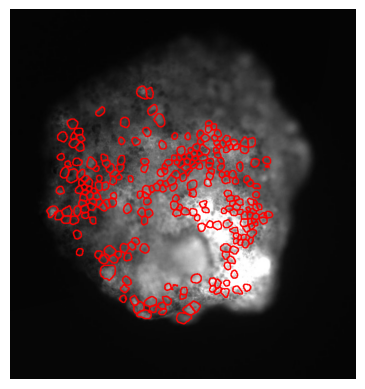

In [21]:
labels = np.unique(pixels_df_before['label'])

# Draw contours

# Note: (0,0) in OpenCV is top left. (0,0) in matplotlib is bottom left

contour_img = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)

for i in labels:
    xs = list(pixels_df_before[pixels_df_before['label']==i]['x'])
    ys = list(pixels_df_before[pixels_df_before['label']==i]['y'])

    mask = np.zeros(contour_img.shape, dtype=int)
    mask[xs,ys]=1
    
    if np.sum(mask) > 0:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(img_before, contours, -1, (255, 0, 0), 2)

fig,ax = plt.subplots(layout='constained')
ax.imshow(img_before)
bbox_before = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_before_segmentation.png', dpi=300, bbox_inches='tight')

After

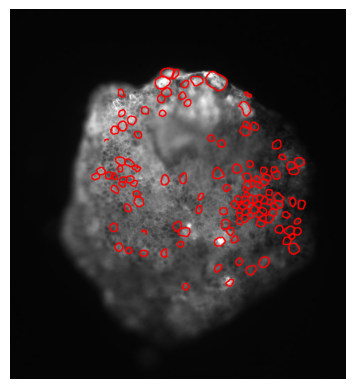

In [22]:
labels = np.unique(pixels_df_after['label'])

# Draw contours

contour_img = cv2.cvtColor(img_after, cv2.COLOR_BGR2GRAY)

for i in labels:
    xs = list(pixels_df_after[pixels_df_after['label']==i]['x'])
    ys = list(pixels_df_after[pixels_df_after['label']==i]['y'])

    mask = np.zeros(contour_img.shape, dtype=int)
    mask[xs,ys]=1
    
    if np.sum(mask) > 0:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(img_after, contours, -1, (255, 0, 0), 2)

fig,ax = plt.subplots(layout='constained')
ax.imshow(img_after)
bbox_after = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_after_segmentation.png', dpi=300, bbox_inches='tight')

### Visualize networks

In [52]:
def plot_edges(ax, mat, com_df, color=(0,0,1,0.6)):
    mat_vals = mat[np.triu_indices(mat.shape[0],k=1)]
    mat_edges_r,mat_edges_c = np.triu_indices(mat.shape[0],k=1)

    for i in range(len(mat_vals)):
        val = mat_vals[i]
        nodei_id = mat_edges_r[i]
        nodej_id = mat_edges_c[i]

        x1 = com_df.iloc[nodei_id]["y"]      
        y1 = com_df.iloc[nodei_id]["x"]      
        
        x2 = com_df.iloc[nodej_id]["y"]      
        y2 = com_df.iloc[nodej_id]["x"]  

        ax.plot([x1,x2],[y1,y2], c=color, linewidth=val)  

In [40]:
NODE_COLOR = 'red'
EDGE_COLOR = (0,0,1,0.6)

Before

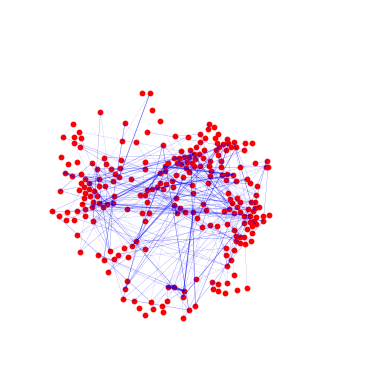

In [54]:
# Plot nodes 

fig,ax = plt.subplots(layout='constained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_before.shape[0], img_before.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
ax.scatter(com_df_before["y"], com_df_before["x"], c=NODE_COLOR, s=10)
plot_edges(ax, fc_before, com_df_before, color=EDGE_COLOR)

plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_before_network.png', dpi=300, bbox_inches='tight')
plt.show()

After

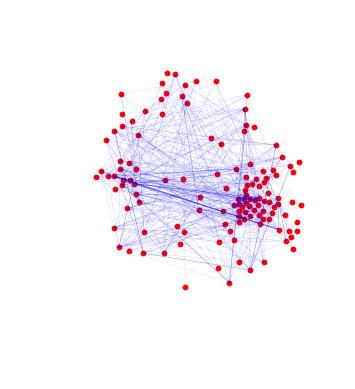

In [57]:
# Plot nodes 

fig,ax = plt.subplots(layout='constained')

# FC
ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.setp(ax.spines.values(), visible=False)

background = np.ones((img_after.shape[0], img_after.shape[1])) # so nodes are in the same position as segmented cells above
ax.imshow(background, cmap='binary')
ax.scatter(com_df_after["y"], com_df_after["x"], c=NODE_COLOR, s=10)
plot_edges(ax, fc_after, com_df_after, color=EDGE_COLOR)

plt.savefig(f'../network_characterization_plots/{BOT}/{BOT}_after_network.png', dpi=300, bbox_inches='tight')
plt.show()

### Number of nodes and edges

In [63]:
node_dict = {'before':[],'after':[]}
edge_dict = {'before':[],'after':[]}
BOTS = ['bot_01', 'bot_02', 'bot_03', 'bot_04', 'bot_05', 'bot_06']

for BOT in BOTS:

    for phase in ['before','after']:

        fc = np.loadtxt('../network_inference_data/fc_matrices/{}_{}_mimat_w.csv'.format(BOT, phase), delimiter=',')

        nodes = fc.shape[0] 
        edges = np.sum(fc[np.triu_indices(fc.shape[0],k=1)]>0)

        node_dict[phase].append(nodes)
        edge_dict[phase].append(edges)

Nodes

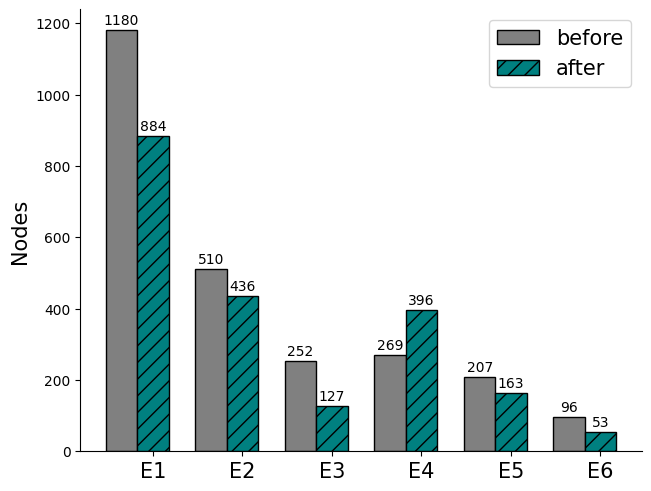

In [86]:
fig, ax = plt.subplots(layout='constrained')

x = np.arange(len(BOTS))

width = 0.35
multiplier = 0

for label, val in node_dict.items():

    offset = width*multiplier
    # rects = ax.bar(x+offset, val, width, label=label)
    if label =='after':
        rects = ax.bar(x+offset, val, width, label=label, color='teal', edgecolor='k', hatch='//')
    else:
        rects = ax.bar(x+offset, val, width, label=label, color='gray', edgecolor='k')

    ax.bar_label(rects, padding=2)
    multiplier+=1

ax.set_ylabel('Nodes', fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=10)

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

ax.set_xticks(x + width, ['E1','E2','E3','E4','E5','E6'], fontsize=15)
ax.legend(loc='upper right', fontsize=15)

plt.savefig('../network_characterization_plots/nodes.png', dpi=300, bbox_inches='tight')


Edges

In [ ]:
fig, ax = plt.subplots(layout='constrained')

x = np.arange(len(BOTS))

width = 0.35
multiplier = 0

for label, val in edge_dict.items():

    offset = width*multiplier
    # rects = ax.bar(x+offset, val, width, label=label)
    if label =='after':
        rects = ax.bar(x+offset, val, width, label=label, color='teal', edgecolor='k', hatch='//')
    else:
        rects = ax.bar(x+offset, val, width, label=label, color='gray', edgecolor='k')

    ax.bar_label(rects, padding=2)
    multiplier+=1

ax.set_ylabel('Edges', fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=10)

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

ax.set_xticks(x + width, ['E1','E2','E3','E4','E5','E6'], fontsize=15)
ax.legend(loc='upper right', fontsize=15)

plt.savefig('../network_characterization_plots/edges.png', dpi=300, bbox_inches='tight')